In [1]:
# Notebook that contains another test-method to determine the greatnes of different performing embeddings
# should prove the hypothesis: The embedding of related drugs and Illness should be close together in the L2 Norm (excluding RotatE and ComplEx)

# to do so, we compare the distance of drug-Illnes pairs against the distance of random pairs.. dr-ill pairs should have a lower distance than the random pairs
# first, choose representative Drug-Illnes pairs 
# second, locate the embeddings of these, calculate the L2 norm
# sample enough and then start all over with the same amount of random pairs


In [2]:
import pandas as pd
import numpy as np
import torch
import random
from scipy.spatial import distance
import seaborn as sns
import math
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

/sc-projects/sc-proj-ukb-cvd/environments/gnn/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [6]:
# function to setup presentable layout (Bachelor Arbeit) for matplotlob
def setup_matplotlib():
    def setSnsStyle(style):
        sns.set(style=style, font_scale=2.0) #1.5
        font = {"family": "serif", "weight": "normal", "size": 45}
        matplotlib.rc("font", **font)
        matplotlib.rcParams["xtick.labelsize"] = 28
        matplotlib.rcParams["ytick.labelsize"] = 28
        matplotlib.rcParams["axes.titlesize"] = 42
        matplotlib.rcParams["axes.labelsize"] = 40
        matplotlib.rcParams["legend.frameon"] = False
        matplotlib.rcParams["legend.title_fontsize"] = 26
        matplotlib.rcParams["legend.loc"] = "best"
        matplotlib.rcParams["legend.fontsize"]= 26 #"small"
        matplotlib.rcParams["legend.fancybox"]= True
        

    setSnsStyle("ticks")

# function to visualize the distance between pairs and random pairs, sampled out of the embeddings and calculate a corresponding metric
# 1. use all pairs in one emb, calculate distance
# 2. sample x random pairse in same emb, calculate distance
# 3. plot pairs and random in one plot, use kde kernell and scale each density distribution equally
# 4. calculate the metric as mean of the empirical distribution of the pairs and random pairs
def vis_met(emb_name, codes, n_random , transformer=False, multiplot=False):
    #load embedding
    missing=0
    path="/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/embeddings_leonard/Embedding_dict_" + emb_name + ".feather"
    emb = pd.read_feather(path)
    if transformer:
        path=("/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/embeddings/Transformer_256.feather")
        emb = pd.read_feather(path)
    
    # calculate the distances between the pairs, codes represent the OMOP names as tupel of str
    dist_list=[]
    index_emb_df = emb.set_index('nodes', drop=True, inplace=False) # TransE_Test
    for c in codes:
        try:
            dist_list.append(distance.euclidean(index_emb_df.loc[c[0]].embeddings , index_emb_df.loc[c[1]].embeddings) )
        except:
            print(f'one of nodes {c} not in {emb_name}')
            missing+=1
        
    # sample random 
    random_nodes=list(emb.sample(n_random).nodes)
    
    # calculate random distances
    dist_random=[]
    for i in range(0,n_random, 2):
        dist_random.append(distance.euclidean(index_emb_df.loc[random_nodes[i]].embeddings , index_emb_df.loc[random_nodes[i+1]].embeddings))

    # create DataFrame in long format to seperate with hue=
    plot_data=pd.DataFrame(columns=["source","distance"])
    plot_data["source"] =["pair" for _ in range(len(codes))] + ["random" for _ in range(math.ceil(n_random/2) - missing)]
    plot_data["distance"] = dist_list + dist_random
    
    # calculate metrix to the emb (<0.5 supports the hypothesis)
    ecdf = ECDF(plot_data[plot_data["source"] == "random"].distance)
    meaningful_pairs_quantiles = ecdf(plot_data[plot_data["source"] == "pair"].distance)
    metric = np.mean(meaningful_pairs_quantiles)
    
    # plotting common_norm=False scales each density independently, so that each area under the courve sums to 1    
    g=sns.displot(data=plot_data,x="distance", hue="source", kind="kde", log_scale=(False, False), common_norm=False)
    plt.title(f'{emb_name}: {metric:.4f}')
    if multiplot:
        return (plot_data, emb_name, metric)
    else:
        #plt.savefig(f'{emb_name} distances')
        #plt.show(g)
        return 0

# function to plot all figures in one
# emb_names: list of str corresponding to the embedding_name.feather file
# codes, n_random: variables for vis_met
# x,y: set the NxM scale of the subplot
# new_names: list with new titles for the embeddings
def multi_vis_met(emb_names, codes,new_names, n_random, n,m, title, multi=True):
    setup_matplotlib()
    vis_met_data=[]
    for emb in emb_names:
        vis_met_data.append(vis_met(emb, codes, n_random , transformer=False, multiplot=multi))
    # generating the subplots
    print(len(vis_met_data))
    ite=0
    fig, axes = plt.subplots(n,m, figsize=(44, 22), sharey=False, sharex=False)
    fig.suptitle('Reasonable pairs distance compared to random pairs distance')
    setup_matplotlib()
    for ax_list in axes:
        for ax in ax_list:
            #g = sns.displot(data=vis_met_data[ite][0], x='distance', hue='source', kind='kde',ax=ax)
            g = sns.kdeplot(data=vis_met_data[ite][0], x='distance', hue='source',ax=ax, common_norm=False, fill=True, linewidth=5)
            ax.set_title(f'{new_names[ite]}: {vis_met_data[ite][2]:.4f}')
            ite+=1
    plt.tight_layout()
    plt.show()
    fig.savefig(title)


In [91]:
# NOT USEFULL !!
# function, that calculates L2 norm and counts the points while comparing
#  a point is achieved if the med-pair is nearer than the random-pair
# compare to different embeddings
def compare(pairs, embs, n=10):
    majority_list=[]
    for emb in embs:
        print(emb)
        # load embs
        path="/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/embeddings_leonard/Embedding_dict_" + emb + ".feather"
        
        embedding_df = pd.read_feather(path)
        index_emb_df = embedding_df.set_index('nodes', drop=True, inplace=False)
        
        majority=0 # more than len(pairs)/2
        for i in range(n):
            better=0
            for pair in pairs:
                x=distance.euclidean(index_emb_df.loc[pair[0]].embeddings , index_emb_df.loc[pair[1]].embeddings)
                y=distance.euclidean(index_emb_df.loc[list(embedding_df.sample(1).nodes)[0]].embeddings,index_emb_df.loc[list(embedding_df.sample(1).nodes)[0]].embeddings)
                if x<y:
                    better+=1
            if better > (len(pairs)/2):
                majority+=1
            #print(better, ' times better out of ', len(pairs))
        majority_list.append((emb,majority))
    
    return majority_list

In [5]:
# load embeddings into DataFrames
embedding_df = pd.read_feather(
    "/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/embeddings_leonard/Embedding_dict_TransE_Test.feather"  #Transformer_256
)

nodes_df =embedding_df['nodes'] #.str.contains('p')] )
nodes_df.drop_duplicates(inplace=True, keep='first')
types_list=[ n for n in nodes_df.values if n.endswith('196523')]
print(types_list)


index_emb_df = embedding_df.set_index('nodes', drop=True, inplace=False)

diabetis_emb = index_emb_df.loc['OMOP_201254'].embeddings # Type 1 diabetis mellitus
insulin_receptor_emb = index_emb_df.loc['OMOP_4066271'].embeddings #4215408 #OMOP_4066271 #not in UMAP

diarrhea_emb = index_emb_df.loc['OMOP_196523'].embeddings 
Tetlo_Med_emb = index_emb_df.loc['OMOP_37110974'].embeddings # not in UMAP

allergic_rhinitis_emb=  index_emb_df.loc['OMOP_257007'].embeddings 
Azelastine_emb=index_emb_df.loc['OMOP_934075'].embeddings

headach_emb =index_emb_df.loc['OMOP_378253'].embeddings
theo_emb =index_emb_df.loc['OMOP_1115008'].embeddings

hypertension_emb=index_emb_df.loc['OMOP_320128'].embeddings #320128 , 4322024
losartan_emb=index_emb_df.loc['OMOP_1367500'].embeddings

smoking_emb=index_emb_df.loc['OMOP_4204653'].embeddings
lungcancer_emb=index_emb_df.loc['OMOP_4038238'].embeddings

asthma_emb=index_emb_df.loc['OMOP_317009'].embeddings
oxcarbazepine_emb=index_emb_df.loc['OMOP_718122'].embeddings

stroke_emb=index_emb_df.loc['OMOP_4099974'].embeddings
orapaxar_emb=index_emb_df.loc['OMOP_44818363'].embeddings # not in UMAP

cirrhosis_emb=index_emb_df.loc['OMOP_4064161'].embeddings
furosemid_emb=index_emb_df.loc['OMOP_956874'].embeddings

copd=index_emb_df.loc['OMOP_4209097'].embeddings
iptratropium_emb=index_emb_df.loc['OMOP_1112921'].embeddings

# Test out name coding
test=index_emb_df.loc['OMOP_40240664'].embeddings


['OMOP_196523', 'OMOP_4196523', 'OMOP_46196523']


In [6]:
# load mapping file, that mapps openTarget Nodes to omop ids

mapping = pd.read_feather('/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/211110_anewbeginning/graph_opentargets_edges_omop_211120.feather' )
ot_omop = mapping[mapping['relationship_id'] == 'Maps OT to OMOP']
ot_omop[ot_omop['concept_id_1'] =='CHEMBL1621597']

,concept_id_1,concept_id_2,concept_name_1,concept_name_2,domain_id_1,domain_id_2,relationship_id
19680,CHEMBL1621597,1112921,None,ipratropium,Drug,Drug,Maps OT to OMOP


In [107]:
# load embeddings for fast experimenting 
# load sample embs : 
pathlist=['TransE_Test', 'RotatE' , 'ComplEx', 'ConvE_t1']#, 'NodePiece_t2', 'random_rotate']
embeddings=[]

for name in pathlist:
    path="/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/embeddings_leonard/Embedding_dict_" + name + ".feather"
    embedding_df = pd.read_feather(path)
    embeddings.append(embedding_df)

 

one of nodes ('OMOP_1506270', 'OMOP_4098179') not in TransE_Test
one of nodes ('OMOP_1550557', 'OMOP_4098179') not in TransE_Test
one of nodes ('OMOP_19061088', 'OMOP_4098179') not in TransE_Test
one of nodes ('OMOP_40163718', 'OMOP_4098179') not in TransE_Test
one of nodes ('OMOP_1506270', 'OMOP_4098179') not in RotatE
one of nodes ('OMOP_1550557', 'OMOP_4098179') not in RotatE
one of nodes ('OMOP_19061088', 'OMOP_4098179') not in RotatE
one of nodes ('OMOP_40163718', 'OMOP_4098179') not in RotatE
one of nodes ('OMOP_1506270', 'OMOP_4098179') not in TransE_less_relations
one of nodes ('OMOP_1550557', 'OMOP_4098179') not in TransE_less_relations
one of nodes ('OMOP_19061088', 'OMOP_4098179') not in TransE_less_relations
one of nodes ('OMOP_40163718', 'OMOP_4098179') not in TransE_less_relations
one of nodes ('OMOP_4230911', 'OMOP_4059699') not in TransE_less_relations
one of nodes ('OMOP_4178367', 'OMOP_437677') not in TransE_less_relations
one of nodes ('OMOP_4178367', 'OMOP_4165995')

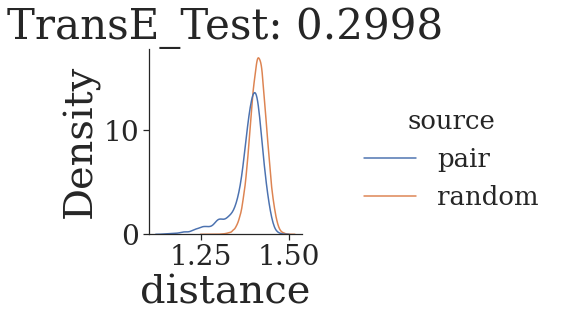

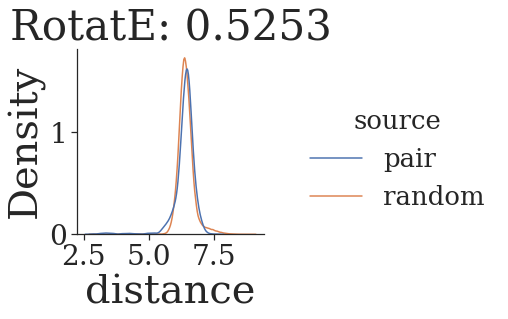

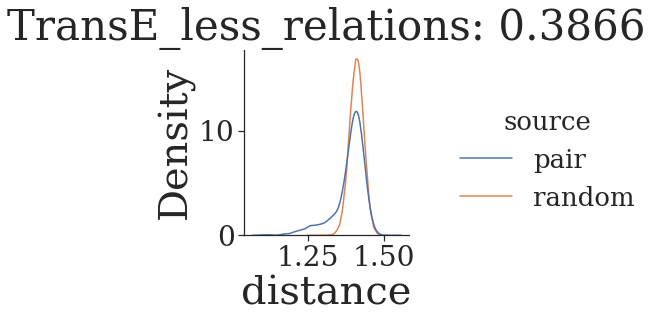

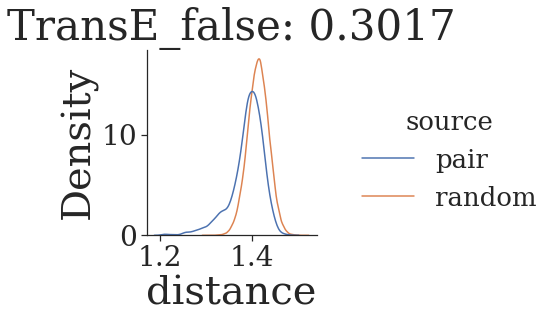

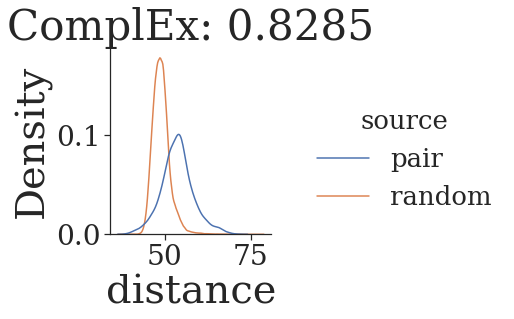

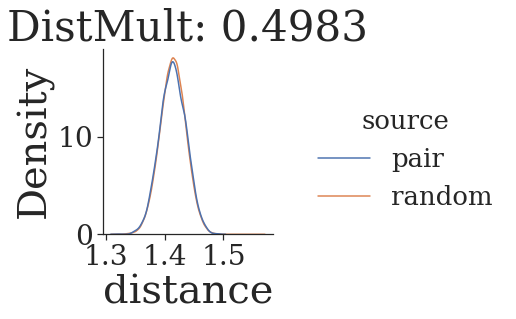

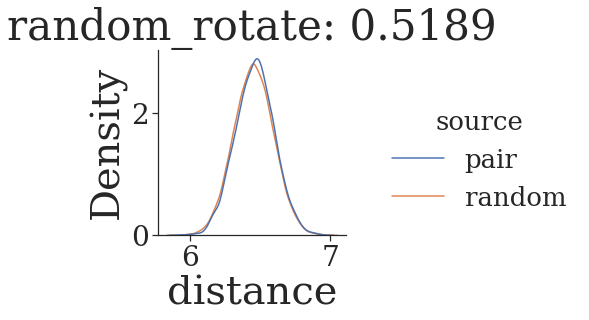

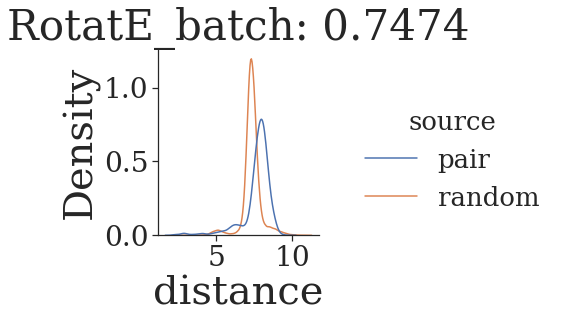

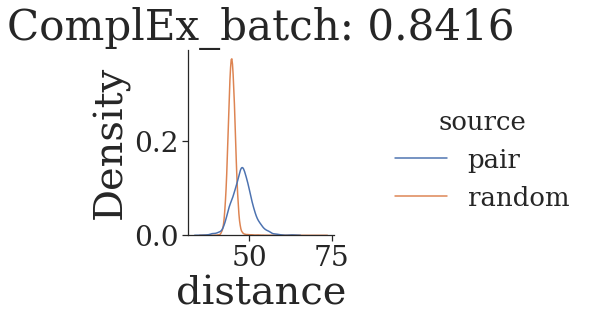

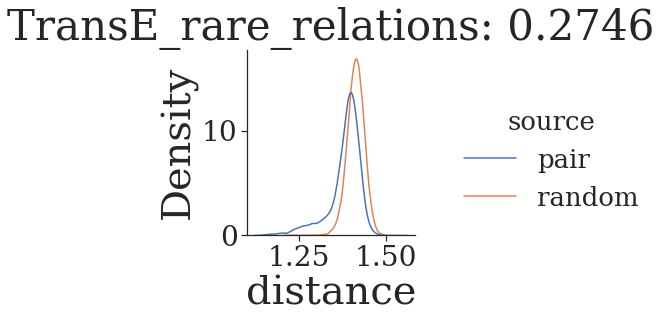

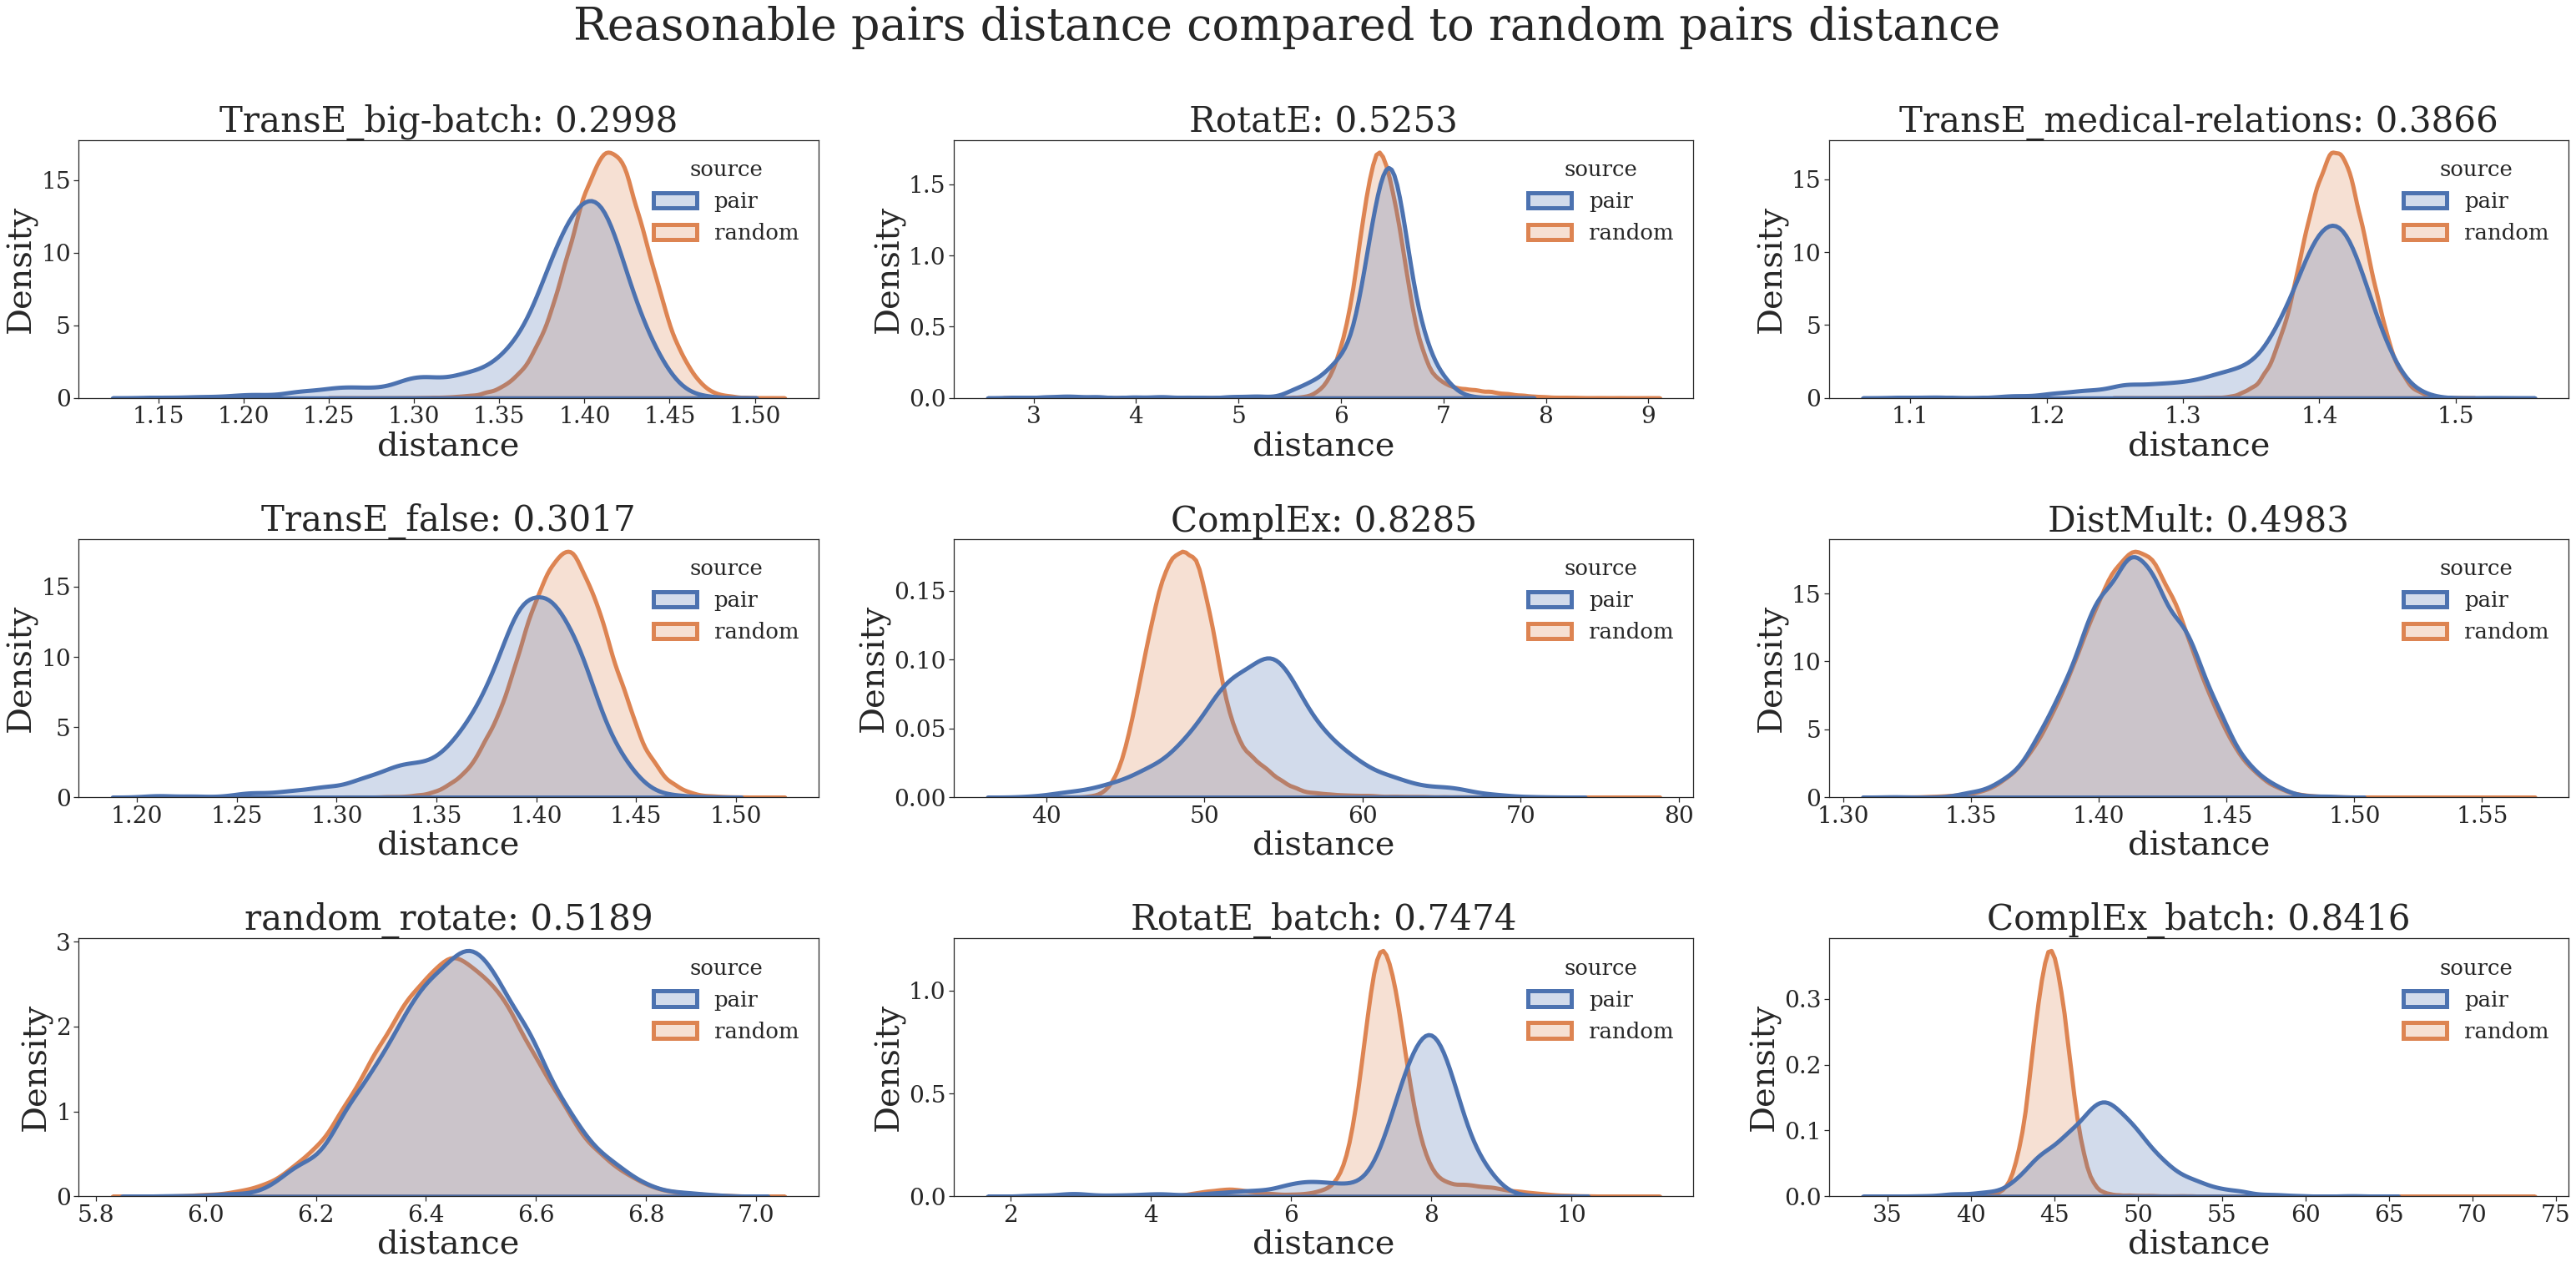

'\n#print(matplotlib.rcParams.keys())\nfor emb in pathlist:\n    #vis_met(emb, big_pairs_list, 200000,transformer=False, multiplot=True )\n    m=0\n    '

In [7]:
# CREATE MULTIPLE DISTANCE PLOTS IN ONE FIGURE FOR BACHELOR THESIS #####


#print(vis_met('NodePiece_t2', big_pairs_list, 200000 , transformer=False, multiplot=True))
setup_matplotlib()
all_embs=['TransE_Test','RotatE','TransE_less_relations','TransE_false','ComplEx','DistMult','random_rotate','RotatE_batch','ComplEx_batch','TransE_rare_relations','TransE_less001','random_normal','RESCAL','TransE_batch','DistMult_t2','TransE','ConvE','MuRE',  'NodePiece_t1','ConvE_t1', 'NodePiece_t2']

#new_names for new title names of the embeddings, acces via iterator
new_names=['TransE_big-batch','RotatE','TransE_medical-relations','TransE_false','ComplEx','DistMult','random_rotate','RotatE_batch','ComplEx_batch']

multi_vis_met(all_embs[:10],big_pairs_list,new_names, 200000, 3,3, "NodePairs-best-final") # 200000




"""
#print(matplotlib.rcParams.keys())
for emb in pathlist:
    #vis_met(emb, big_pairs_list, 200000,transformer=False, multiplot=True )
    m=0
    """

In [6]:
# use DISPLOT with kde to present histogram 
# 1. use all pairs in one emb, calculate distance
# 2. sample x random pairse in same emb, calculate distance
# 3. plot pairs and random in one plot, use kde kernell and scale each density distribution equally
# 4. calculate the metric as mean of the empirical distribution of the pairs and random pairs

dist_list=[]
index_emb_df = embeddings[0].set_index('nodes', drop=True, inplace=False) # TransE_Test
for c in codes:
    dist_list.append(distance.euclidean(index_emb_df.loc[c[0]].embeddings , index_emb_df.loc[c[1]].embeddings) )
print(dist_list)

# sample random 
n_random=20000
random_nodes=list(embeddings[0].sample(n_random).nodes)
print(type(random_nodes))

# calculate distance
dist_random=[]
for i in range(0,n_random, 2):
    dist_random.append(distance.euclidean(index_emb_df.loc[random_nodes[i]].embeddings , index_emb_df.loc[random_nodes[i+1]].embeddings))
print(len(dist_random))

# CREATE DATAFRAME FOR MULTIPLE PLOTTING
# long format to seperate with hue=
plot_data=pd.DataFrame(columns=["source","distance"])
plot_data["source"] =["pair" for _ in range(10)] + ["random" for _ in range(math.ceil(n_random/2))]
plot_data["distance"] = dist_list + dist_random

# just two plots in one scale
sns.displot(data=plot_data,x="distance", hue="source", kind="kde", log_scale=(False, False), common_norm=False) # common_norm=False scales each density independently, so that each area under the courve sums to 1


# CALCULATING THE METRIC as mean of the empirical distribution of the pairs and random pairs
# < 0.5 -> distance between pairs are lower than the random_pairs
# 0.5 -> distances approximatly the same
# > 0.5 -> distances between pairs are greater than between random pairs

from statsmodels.distributions.empirical_distribution import ECDF
    
ecdf = ECDF(plot_data[plot_data["source"] == "random"].distance)
meaningful_pairs_quantiles = ecdf(plot_data[plot_data["source"] == "pair"].distance)
metric = np.mean(meaningful_pairs_quantiles)
print('metric : ', metric)

NameError: name 'embeddings' is not defined

In [4]:
# LOAD CODES DATA AND SPECIFY EMBEDDING NAMES


big_codes=pd.read_feather('/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/211110_anewbeginning/drug_disease_pairs_220608.feather') #14323 
big_codes_omop=pd.read_feather('/sc-projects/sc-proj-ukb-cvd/data/2_datasets_pre/220208_graphembeddings/sensible_pairs/220609_sensible_pairs_omop.feather') #753
print(f'big_codes{len(big_codes)} big_codes_omop: {len( big_codes_omop)} added: {len(big_codes)+len(big_codes_omop)}')

codes=[('OMOP_201254','OMOP_4066271'),('OMOP_196523' , 'OMOP_37110974'), ('OMOP_257007','OMOP_934075'), ('OMOP_378253', 'OMOP_1115008'),('OMOP_320128', 'OMOP_1367500'), ('OMOP_317009','OMOP_718122'),( 'OMOP_4204653', 'OMOP_4038238'),('OMOP_4099974', 'OMOP_44818363'),('OMOP_4064161','OMOP_956874') ,('OMOP_4209097','OMOP_1112921') ]
whole = ['TransE_Test', 'RotatE', 'ComplEx', 'RotatE_batch', 'random_rotate', 'DistMult', 'random_normal', 'TransE', 'MuRE', 'NodePiece_t1', 'ConvE_t1', 'NodePiece_t2']
bestVSworst = ['TransE_Test', 'RotatE', 'random_rotate', 'DistMult','MuRE', 'NodePiece_t1', 'ConvE_t1', 'NodePiece_t2']

# appending disease_pairs with omop diesease pairs
big_codes_omop.rename(columns = {'from_node':'omop_id_1', 'to_node':'omop_id_2'}, inplace = True)
big_codes_omop.drop(columns=['edge_type'], inplace=True)
big_codes = big_codes[['omop_id_1', 'omop_id_2']]

big_codes_all= pd.merge(big_codes, big_codes_omop, how="outer") # SQL Full join

#investigate pairs from feather
dtemp={'omop_id_1': big_codes_all['omop_id_1'], 'omop_id_2': big_codes_all['omop_id_2']}

big_pairs = pd.DataFrame(data=dtemp)
print('lenght bevor: ', len(big_pairs))
print(big_pairs)
# drop duplicate rows
big_pairs.drop_duplicates(inplace=True) # on all columns
print('lenght after drop duplicates: ', len(big_pairs))

big_pairs_list =list(big_pairs.to_records(index=False))

big_codes14323 big_codes_omop: 753 added: 15076
lenght bevor:  15076
          omop_id_1      omop_id_2
0      OMOP_1311078    OMOP_134305
1      OMOP_1311078    OMOP_134305
2      OMOP_1311078    OMOP_134305
3      OMOP_1311078    OMOP_134305
4      OMOP_1311078    OMOP_134305
...             ...            ...
15071   OMOP_437409    OMOP_435127
15072   OMOP_437409  OMOP_43530691
15073   OMOP_437409  OMOP_43530691
15074   OMOP_443733    OMOP_201826
15075   OMOP_440577    OMOP_440921

[15076 rows x 2 columns]
lenght after drop duplicates:  4459


In [ ]:
# for loop to count the related sample comparison which is better
for i in range(15):
    better=0
    for pair in pairs:
        x=distance.euclidean(pair[0],pair[1])
        print(x)
        y=distance.euclidean(index_emb_df.loc[list(embedding_df.sample(1).nodes)[0]].embeddings,index_emb_df.loc[list(embedding_df.sample(1).nodes)[0]].embeddings)
        if x<y: better+=1
    print('\n', better, ' times better out of ', len(pairs))